In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch import optim
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import copy

# from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class LeNet(nn.Module):
    def __init__(self, max_growth):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Linear(400,500+max_growth)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500+max_growth,100+max_growth)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(100+max_growth,10)

        #Custom Functionality
        self.max_growth = max_growth
        previous_module = self.parameters_to_prune()[0][0]

        for module, name in self.parameters_to_prune()[1:]:

          #Prune incoming weights (Previous layers outgoing weights)
          if previous_module != None:
            mask = torch.ones(np.shape(previous_module.weight))
            mask[-max_growth:,:] = 0
            prune.custom_from_mask(previous_module, name, mask)
            
          #Prune outgoing weights
          mask = torch.ones(np.shape(module.weight))
          mask[:,-max_growth:] = 0
          prune.custom_from_mask(module, name, mask)

          previous_module = module  #save layer for next iteration
        

    def parameters_to_prune(self):
        return ((self.fc1, 'weight'),
                (self.fc2, 'weight'),
                (self.fc3, 'weight'),) 
    #End Custom Functionality

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        return out

In [7]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_train_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)

augmented_train_loader = torch.utils.data.DataLoader(dataset = augmented_train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_test_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


augmented_test_loader = torch.utils.data.DataLoader(dataset = augmented_test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


# train_dataset, test_dataset = train_dataset.cuda(), test_dataset.cuda()

#Setting the loss function
cost = nn.CrossEntropyLoss()

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

def train(model,train_loader,test_loader,num_epochs,optimizer):
  accuracy=[]
  model.to(device)
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      accuracy.append(test(model,test_loader))
    #   print(accuracy)
      for i, (images, labels) in enumerate(train_loader): 
          
          images = images.to(device)
          labels = labels.to(device)
          
          #Forward pass
          outputs = model(images)
          loss = cost(outputs, labels)
            
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
              
          if (i+1) % 400 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  return accuracy
  
def test(model, test_loader):
    # print("model: ",type(model))
    # print("test_loader: ",type(test_loader))
    # model.to(device)
    # test_loader.to(device)
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader): 
            images, labels = images.cuda(), labels.cuda()
            # model=model.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
#All in One Method to Find Lottery Tickets given a model and dataset, saves models in shared drive
def find_ticket(model, name, train_loader, test_loader, start_iter = 0, end_iter = 30, num_epochs = 10, learning_rate = .001, prune_amount = .2, k = 3):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  #If training has already been saved
  try:
    model.load_state_dict(torch.load('private/cifar/models/'+ name + '_RewindWeights' + '_' + str(k)))
  except:
    train(model, train_loader,test_loader,num_epochs = k, optimizer = optimizer)  #Save Kth epoch model
    torch.save(model.state_dict(), 'private/cifar/models/' + name + '_RewindWeights' + '_' + str(k))

  model_rewind = LeNet(max_growth = model.max_growth) #Save as separate model so we can rewind our weights back to this
  model_rewind.load_state_dict(torch.load('private/cifar/models/'+ name + '_RewindWeights' + '_' + str(k)))

  train(model, train_loader,test_loader,num_epochs = num_epochs - k, optimizer = optimizer) #Finish off training
  accuracy = []

  for i in range(start_iter, end_iter): 
    #Prune
    prune.global_unstructured(model.parameters_to_prune(),pruning_method=prune.L1Unstructured,amount=prune_amount,)
    
    #Rewind Weights
    for idx, (module, _) in enumerate(model.parameters_to_prune()):
      with torch.no_grad():
        module_rewind = model_rewind.parameters_to_prune()[idx][0]
        module.weight_orig.copy_(module_rewind.weight)

    print(
    "Global Sparsity: {:.2f}%".format(
        100. * (float(torch.sum(model.fc3.weight == 0)) + float(torch.sum(model.fc1.weight == 0)) + float(torch.sum(model.fc2.weight == 0)))
        / (float(model.fc3.weight.nelement()) + float(model.fc1.weight.nelement()) + float(model.fc2.weight.nelement()))
    )
    )
    
    #Train
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
    accuracy.append(test(model, test_loader))

    plt.plot(np.arange(len(accuracy)), accuracy)
    plt.show()
    print('Saving iteration ', str(i+1))
    torch.save(model.state_dict(), 'private/cifar/models/' + name + '_iter' + str(i+1)) 

def grow(model, parameters_to_prune, amount):
  previous_module = parameters_to_prune[0][0]

  for module, name in parameters_to_prune[1:]:
    mask = module.get_buffer('weight_mask').data
    #Pick Suitable Locations
    omega = []
    for idx, val in enumerate(torch.sum(mask, dim = 0)): 
      if val == 0:
        omega.append(idx)

    indices = np.random.choice(omega, size = min(len(omega), amount), replace = False)
    
    #Grow at these indices
    module.get_buffer('weight_mask')[:,indices] = 1
    prune.custom_from_mask(module,'weight', torch.ones(module.weight.size()))

    previous_module.get_buffer('weight_mask')[indices,:] = 1
    prune.custom_from_mask(previous_module,'weight', torch.ones(previous_module.weight.size()))  

## Testing Adam gradient descent ##

Test Accuracy of the model on the 10000 test images: 0.06
Epoch [1/50], Step [400/782], Loss: 1.5729
Test Accuracy of the model on the 10000 test images: 0.50
Epoch [2/50], Step [400/782], Loss: 1.3458
Test Accuracy of the model on the 10000 test images: 0.44
Epoch [3/50], Step [400/782], Loss: 1.0816
Test Accuracy of the model on the 10000 test images: 0.69
Epoch [4/50], Step [400/782], Loss: 1.0190
Test Accuracy of the model on the 10000 test images: 0.69
Epoch [5/50], Step [400/782], Loss: 1.1324
Test Accuracy of the model on the 10000 test images: 0.62
Epoch [6/50], Step [400/782], Loss: 1.0795
Test Accuracy of the model on the 10000 test images: 0.44
Epoch [7/50], Step [400/782], Loss: 0.6320
Test Accuracy of the model on the 10000 test images: 0.44
Epoch [8/50], Step [400/782], Loss: 0.4996
Test Accuracy of the model on the 10000 test images: 0.75
Epoch [9/50], Step [400/782], Loss: 0.6284
Test Accuracy of the model on the 10000 test images: 0.50
Epoch [10/50], Step [400/782], Lo

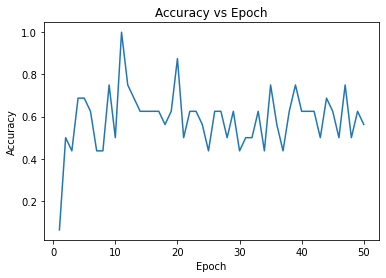

In [8]:
max_growth = 20
num_epochs = 50
gamma = 10 #num new nodes on first growth

model2 = LeNet(max_growth = max_growth)
model2=model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

accur=train(model2, train_loader,test_loader,num_epochs, optimizer = optimizer)

epoch=np.linspace(1,num_epochs,num_epochs)
plt.plot(epoch,accur)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()





In [13]:
test(model2,test_loader)

model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.50


0.5

In [26]:
#Generate Tickets

max_growth = 50
model = LeNet(max_growth = max_growth)
find_ticket(model, 'CIFAR10', train_loader, test_loader)

Epoch [1/7], Step [400/782], Loss: 1.3490
Epoch [2/7], Step [400/782], Loss: 0.8731
Epoch [3/7], Step [400/782], Loss: 0.9381
Epoch [4/7], Step [400/782], Loss: 1.0673
Epoch [5/7], Step [400/782], Loss: 0.4895
Epoch [6/7], Step [400/782], Loss: 0.5540
Epoch [7/7], Step [400/782], Loss: 0.7648
Global Sparsity: 33.95%
Epoch [1/10], Step [400/782], Loss: 1.4555
Epoch [2/10], Step [400/782], Loss: 0.9139
Epoch [3/10], Step [400/782], Loss: 1.0598
Epoch [4/10], Step [400/782], Loss: 0.9267
Epoch [5/10], Step [400/782], Loss: 0.8045
Epoch [6/10], Step [400/782], Loss: 0.4943
Epoch [7/10], Step [400/782], Loss: 0.6718
Epoch [8/10], Step [400/782], Loss: 0.5182
Epoch [9/10], Step [400/782], Loss: 0.4728
Epoch [10/10], Step [400/782], Loss: 0.4618


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor